# Development notebook for processing sexual dimorphism data
## This notebook takes as input the csv produced from 'sample_reader_nb', which represents the load and rearranged sexual dimorphism data matrix

In [1]:
# Isaac Berez
# 17.01.23
import sys
from scipy.io import mmread
import os
import glob
import pandas as pd
import numpy as np
from pandas_ods_reader import read_ods
from copy import deepcopy
import pprint
import json
import re
from datetime import datetime
import logging
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor

import dimorph_processing as dp

%load_ext autoreload
%autoreload 2

### 1. Read in meta data and big data file, create meta_data_df, and remove cntnp strain

In [2]:
meta_data_df, dimorph_df, dimorph_df_bool = dp.load_data(metadata_file = '/bigdata/isaac/meta_data_dict_040224.json', 
                                                         bigdata_file = '/bigdata/isaac/dimorph_df.feather')

In [3]:
dimorph_df.shape

(27933, 79613)

In [4]:
meta_data_df.shape

(27, 79613)

#### create boolean version of gene expression data frame, used in level 2 and level 3 filtering

In [3]:
# create boolean version of the dataframe, where any expression >0 = 1,
# used to calculate total genes/cell
#dimorph_df_bool = dimorph_df.mask(dimorph_df>0, other = 1)
dimorph_df_bool.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCAAGTACTGTC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCAGTAACATAG-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,...,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGAGTGCTCGC-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2,TTTGTTGTCGAAGGAC-1_10X37_2,TTTGTTGTCTCTGCTG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,0,1,0,1,0,0,1,1,1,0,...,1,0,1,0,1,1,1,0,0,0
0610009B22Rik,0,0,0,1,0,1,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
0610009L18Rik,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0
0610009O20Rik,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610010F05Rik,0,0,1,0,0,0,1,1,1,0,...,1,0,1,0,1,0,1,0,0,0


### 2. Calculate molecules/cell and genes/cell vectors, keep only cells with >2500 mol/cell and >2000 genes/cell

In [6]:
dimorph_df_l2, dimorph_df_bool_l2, meta_data_df_l2 = dp.cell_exclusion(threshold_m = 2500, 
                                                      threshold_g = 2000,
                                                      df_bool = dimorph_df_bool,
                                                      meta_data_df = meta_data_df,
                                                      df = dimorph_df)
dimorph_df_l2.head()

Total cells reduced from 79613 to 43492


,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,0,2,2,0,1,3,2,0,1,1,...,0,1,1,1,0,1,2,1,1,0
0610009B22Rik,0,0,1,2,2,0,1,0,0,0,...,1,0,0,0,0,0,2,0,0,0
0610009L18Rik,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
0610009O20Rik,1,0,0,1,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
0610010F05Rik,0,0,0,0,2,1,1,0,0,0,...,1,0,0,1,0,2,1,0,1,0


In [7]:
dimorph_df_l2.shape

(27933, 43492)

### 3. Gene Exclusion - Keep only genes expressed in >10 cells, <50% of all cells

In [8]:
dimorph_df_l3, dimorph_df_bool_l3, meta_data_df_l3 = dp.gene_exclusion(num_cell_lwr_bound=10,
                                                      percent_cell_upper_bound=50,
                                                     df_bool=dimorph_df_bool_l2,
                                                     df = dimorph_df_l2,
                                                     meta_data_df = meta_data_df_l2)
dimorph_df_l3.head()

Total genes reduced from 27933 to 17081


,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,0,2,2,0,1,3,2,0,1,1,...,0,1,1,1,0,1,2,1,1,0
0610009B22Rik,0,0,1,2,2,0,1,0,0,0,...,1,0,0,0,0,0,2,0,0,0
0610009L18Rik,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
0610009O20Rik,1,0,0,1,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
0610010F05Rik,0,0,0,0,2,1,1,0,0,0,...,1,0,0,1,0,2,1,0,1,0


In [9]:
dimorph_df_l3.shape

(17081, 43492)

#### Sanity Check if known sex specific genes in dimorph_df_l2

In [10]:
print ('Xist' in dimorph_df_l2.index)
print ('Tsix' in dimorph_df_l2.index)
print ('Ddx3y' in dimorph_df_l2.index)
print ('Eif2s3y' in dimorph_df_l2.index)
print ('Kdm5d' in dimorph_df_l2.index)
print ('Uty' in dimorph_df_l2.index)

True
True
True
True
True
True


num m cells: 19749 num f cells: 23743


<IPython.core.display.Javascript object>


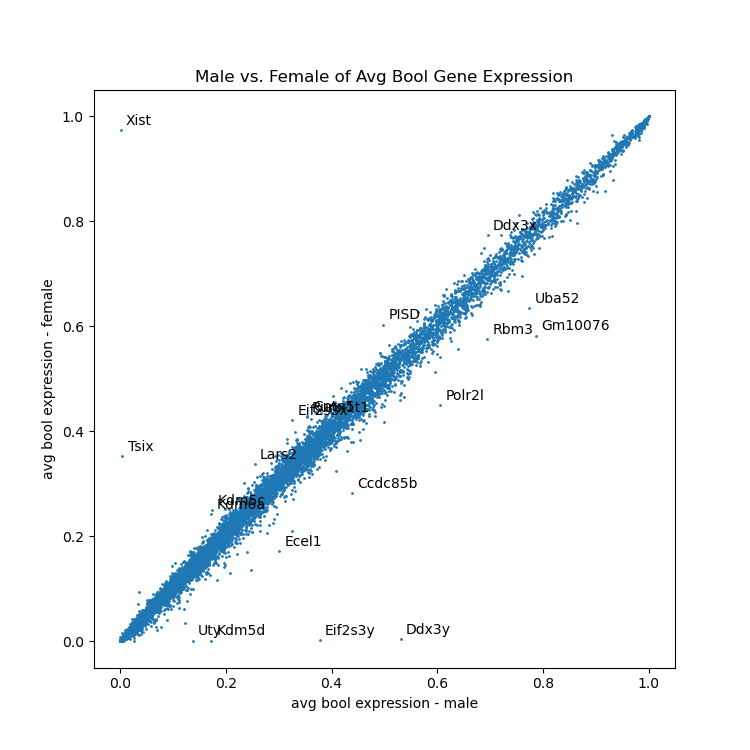

In [11]:
%matplotlib notebook
avg_bool_mf_df_sorted_l2 = dp.avg_bool_gene_expression_by_sex(df_bool = dimorph_df_bool_l2,
                                                              meta_data_df=meta_data_df_l2,
                                                             num_top_genes=10,
                                                             plot_flag=1)

### 4. CV vs. Mean (Poisson filter)

In [12]:
dimorph_df_l3.shape

(17081, 43492)

In [13]:
dimorph_df_l3.iloc[:5,:5]

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2
gene,,,,,
0610007P14Rik,0,2,2,0,1
0610009B22Rik,0,0,1,2,2
0610009L18Rik,0,0,0,0,1
0610009O20Rik,1,0,0,1,1
0610010F05Rik,0,0,0,0,2


##### normalization - sum each column of dimorph df, then divide each expression value by this corresponding column sum

In [14]:
column_sums = dimorph_df_l3.loc[:,dimorph_df_l3.columns].sum(axis=0)
column_sums

AAACCCAAGAGCATAT-1_10X51_2    1286
AAACCCAAGCCTCAGC-1_10X51_2    4324
AAACCCACACAACGTT-1_10X51_2    2827
AAACCCATCACTAGCA-1_10X51_2    2725
AAACGAACACTCCGAG-1_10X51_2    3186
                              ... 
TTTGTTGAGAAATTCG-1_10X37_2    6274
TTTGTTGCAAGGTCAG-1_10X37_2    2556
TTTGTTGCACCGCTGA-1_10X37_2    2811
TTTGTTGGTCCATAGT-1_10X37_2    2017
TTTGTTGGTTGCGAAG-1_10X37_2    1483
Length: 43492, dtype: int64

In [15]:
column_sums.shape

(43492,)

In [16]:
dimorph_df_l3_n = dimorph_df_l3.div(column_sums)

In [17]:
dimorph_df_l3_n.iloc[:5,:5]

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2
gene,,,,,
0610007P14Rik,0.000000,0.000463,0.000707,0.000000,0.000314
0610009B22Rik,0.000000,0.000000,0.000354,0.000734,0.000628
0610009L18Rik,0.000000,0.000000,0.000000,0.000000,0.000314
0610009O20Rik,0.000778,0.000000,0.000000,0.000367,0.000314
0610010F05Rik,0.000000,0.000000,0.000000,0.000000,0.000628


In [18]:
scale_factor = 20000
dimorph_df_l3_n = dimorph_df_l3_n.multiply(scale_factor)
dimorph_df_l3_n.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,0.0000,9.250694,14.149275,0.000000,6.277464,12.823253,11.204482,0.0,4.62963,6.170935,...,0.000000,11.191942,7.052186,6.884682,0.0,3.187759,15.649452,7.114906,9.915716,0.0
0610009B22Rik,0.0000,0.000000,7.074637,14.678899,12.554928,0.000000,5.602241,0.0,0.00000,0.000000,...,4.358248,0.000000,0.000000,0.000000,0.0,0.000000,15.649452,0.000000,0.000000,0.0
0610009L18Rik,0.0000,0.000000,0.000000,0.000000,6.277464,4.274418,0.000000,0.0,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,7.824726,0.000000,9.915716,0.0
0610009O20Rik,15.5521,0.000000,0.000000,7.339450,6.277464,0.000000,0.000000,0.0,0.00000,0.000000,...,4.358248,0.000000,7.052186,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
0610010F05Rik,0.0000,0.000000,0.000000,0.000000,12.554928,4.274418,5.602241,0.0,0.00000,0.000000,...,4.358248,0.000000,0.000000,6.884682,0.0,6.375518,7.824726,0.000000,9.915716,0.0


In [19]:

mu = dimorph_df_l3_n.mean(axis=1)
sigma = dimorph_df_l3_n.std(axis=1)
cv = sigma/mu
log2_mu = np.log2(mu)
log2_cv = np.log2(cv)

#delta = log2_cv - log2_mu
#delta

In [20]:
X = np.reshape(np.array(log2_mu),(log2_mu.shape[0],1))
y = np.reshape(np.array(log2_cv),(log2_cv.shape[0],1))
paramfit = LinearRegression().fit(X, y)
log2_cv_pred = paramfit.predict(X)

paramfit_h = HuberRegressor().fit(X,np.ravel(y))
log2_cv_pred_h = paramfit_h.predict(X)

delta_y_2_pred = y - log2_cv_pred

In [21]:
delta_y_2_pred.shape

(17081, 1)

In [22]:
delta_y_2_pred = np.reshape(delta_y_2_pred, (delta_y_2_pred.shape[0],))

In [23]:
delta_y_2_pred.shape

(17081,)

In [24]:
log_mucv_df = pd.DataFrame({'log2mu':log2_mu, 'log2cv':log2_cv, 'delta': delta_y_2_pred })
log_mucv_df.head()

,log2mu,log2cv,delta
gene,,,
0610007P14Rik,2.545403,0.402732,-0.084992
0610009B22Rik,1.597331,0.869813,-0.080144
0610009L18Rik,0.528353,1.417195,-0.053943
0610009O20Rik,0.348351,1.453584,-0.105314
0610010F05Rik,1.520490,0.859157,-0.128264


In [25]:
num_top_genes = 30
log_mucv_df_sorted = log_mucv_df.sort_values(by = 'delta')

pos = np.array(log_mucv_df_sorted.iloc[-num_top_genes:,0:2])
genes = log_mucv_df_sorted.iloc[-num_top_genes:].index


<IPython.core.display.Javascript object>


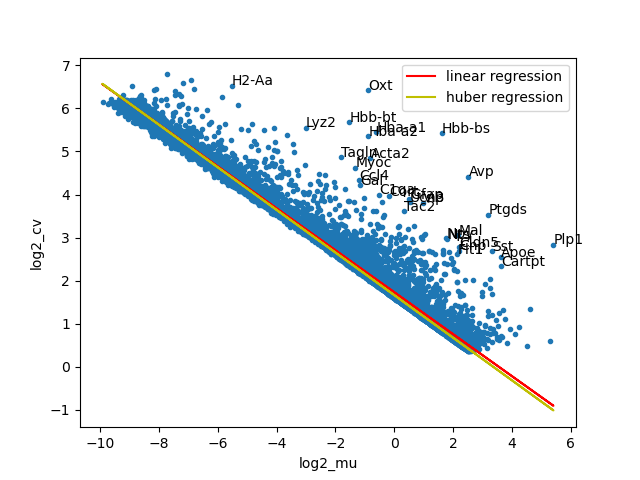

In [30]:
ax, fig = plt.subplots()
plt.scatter(log2_mu,log2_cv, marker = '.')
plt.xlabel('log2_mu')
plt.ylabel('log2_cv')

plt.plot(log2_mu, log2_cv_pred, c= 'r', label = 'linear regression')
plt.plot(log2_mu, log2_cv_pred_h, c = 'y', label = 'huber regression')

#plt.xlim([-14,6])

plt.legend()

offset = 0.01
for i in range(len(pos)):
    plt.text(pos[i][0]+offset,pos[i][1]+offset,genes[i])


plt.show()